In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime as dt
from pandas_datareader import DataReader as DR
import seaborn as sb
import numdifftools as nd
from wquantiles import quantile
import statsmodels.api as sm

from scipy.stats import norm,t,truncnorm
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import multivariate_t as mvt
from scipy.spatial import Delaunay as TRI
from scipy.interpolate import LinearNDInterpolator as ITP
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint as NonlinCons
from scipy.stats import gaussian_kde as sciKDE

from sklearn.linear_model import LinearRegression as Linear
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KernelDensity as sklKDE

import warnings
warnings.filterwarnings("ignore")

# Define the experiment class

In [2]:
class MLE:
    def __init__(self,dim,sigma):
        self.dim=dim
        self.T=lambda x: mvnorm.pdf(x=x,mean=np.zeros(dim))
        self.iP=lambda x: mvnorm.pdf(x=x,mean=np.zeros(dim),cov=sigma**2)
        self.iS=lambda size: mvnorm.rvs(size=size,mean=np.zeros(dim),cov=sigma**2)
        
    def __estimate(self,W,name,asym=True):
        Z=np.mean(W)
        err=np.abs(Z-1)
        if asym:
            aVar=np.var(W)
            aErr=np.sqrt(aVar/W.size)
            print('{} est: {:.4f}; err: {:.4f}; a-var: {:.4f}; a-err: {:.4f}'.format(name,Z,err,aVar,aErr))
        else:
            print('{} est: {:.4f}; err: {:.4f}'.format(name,Z,err))
        
    def estimate_IS(self,size):
        S=self.iS(size)
        W=self.T(S)/self.iP(S)
        self.__estimate(W,'IS')
    
    def draw_TP(self,P,x,name,dim=0):
        X=np.zeros([x.size,self.dim])
        X[:,dim]=x
        ratio=np.reshape(self.T(np.zeros(self.dim))/P(np.zeros([1,self.dim])),1)[0]
        print('------------ pdf ratio at origin: {:.2f} ------------'.format(ratio))
        
        fig,ax=plt.subplots(figsize=(7,4))
        ax.plot(x,self.T(X))
        ax.plot(x,P(X))
        if name=='nonparametric':
            one=np.zeros(self.dim)
            one[dim]=1
            rW=np.array([self.h(one*loc,loc) for loc in self.rS])
            rW=rW/rW.max()*P(np.zeros([1,self.dim]))[0]
            rWmeans=np.ones_like(rW)*rW.mean()

            ax.plot(x,self.mP(X))
            ax.hist(self.rS[:,dim],bins=2*rW.size,weights=rWmeans)
            ax.hist(self.rS[:,dim],bins=2*rW.size,weights=rW)
            ax.legend(['target','nonparametric proposal','mixture proposal','centers','centers with weight'])
        elif name=='regression':
            G=self.G(X)
            rPO=self.regO.coef_.dot(G)+self.regO.intercept_*P(X)
            rPL=self.regL.coef_.dot(G)+self.regL.intercept_*P(X)
            mid=int(x.size/2)
            print('regression ratios: ordinary {:.4f}, lasso {:.4f}'\
                  .format(self.T(X[mid])/rPO[mid],self.T(X[mid])/rPL[mid]))
            
            ax.plot(x,rPO)
            ax.plot(x,rPL)
            ax.legend(['target','mixture proposal','ordinary regression','lasso regression'])
        else:
            ax.legend(['target','{} proposal'.format(name)])
            
        ax.set_title('{}-D target and {} proposal (cross-sectional view)'.format(self.dim,name))
        plt.show()
        
    def resample(self,size,ratio):
        S=self.iS(ratio*size)
        p=self.T(S)/self.iP(S)
        index=np.arange(S.shape[0])
        choice=np.random.choice(index,size,p=p/np.sum(p),replace=True)
        
        self.rS=S[choice]
        self.rSset=S[list(set(choice))]
        print('resample rate: {}/{}'.format(self.rSset.shape[0],size))
        
    def estimate_NIS(self,size,rate,bdwth='scott'):
        if(type(bdwth)==str):
            tmp=sciKDE(self.rS.T,bw_method=bdwth)
            bdwth=np.mean(np.sqrt(np.diag(tmp.covariance_factor()*np.cov(self.rS.T))))
            print('bdwth: {:.4f}'.format(bdwth))
        
        self.bdwth=bdwth
        self.kde=sklKDE(kernel='gaussian',bandwidth=bdwth).fit(self.rS)
        self.h=lambda x,loc: mvnorm.pdf(x=x,mean=loc,cov=self.bdwth**2)
        self.G=lambda x: np.array([self.h(x,loc) for loc in self.rSset])-self.iP(x)
        
        self.nP=lambda x: np.exp(self.kde.score_samples(x))
        self.nS=lambda size: self.kde.sample(size)
        S=self.nS(size)
        W=self.T(S)/self.nP(S)
        self.__estimate(W,'NIS')
        
        self.mP=lambda x: (1-rate)*self.iP(x)+rate*self.nP(x)
        self.mS=lambda size: np.vstack([self.iS(size-round(rate*size)),self.nS(round(rate*size))])
        self.S=self.mS(size)
        W=self.T(self.S)/self.mP(self.S)
        self.__estimate(W,'MIS')
        
    def estimate_RIS(self,alpha):
        X=(self.G(self.S)/self.mP(self.S)).T
        y=self.T(self.S)/self.mP(self.S)
        self.regO=Linear().fit(X,y)
        self.regL=Lasso(alpha).fit(X,y)
        print('Ordinary R2: {:.4f}; Lasso R2: {:.4f}'.format(self.regO.score(X,y),self.regL.score(X,y)))
        
        W=y-X.dot(self.regO.coef_)
        self.__estimate(W,'RIS(Ord)')
        W=y-X.dot(self.regL.coef_)
        self.__estimate(W,'RIS(Las)')
    
    def estimate_MLE(self,opt=False):
        mP=self.mP(self.S)
        G=self.G(self.S)
        target=lambda zeta: -np.mean(np.log(mP+zeta.dot(G)))
        gradient=lambda zeta: -np.mean(G/(mP+zeta.dot(G)),axis=1)
        zeta0=np.zeros(G.shape[0])
        grad0=gradient(zeta0)
        print('Reference:')
        print('origin: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta0),grad0.min(),grad0.mean(),grad0.max(),grad0.std()))
        
        print()
        print('Theoretical results:')
        X=(G/mP).T
        XX=X-X.mean(axis=0)
        zeta1=np.linalg.solve(XX.T.dot(XX),X.sum(axis=0))
        print('MLE(The) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
              .format(zeta1.min(),zeta1.mean(),zeta1.max(),zeta1.std(),np.sqrt(np.sum(zeta1**2))))
        grad1=gradient(zeta1)
        print('theory: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta1),grad1.min(),grad1.mean(),grad1.max(),grad1.std()))
        W=(self.T(self.S)/mP)*(1-XX.dot(zeta1))
        self.__estimate(W,'RIS(The)',asym=False)
        W=self.T(self.S)/(mP+zeta1.dot(G))
        self.__estimate(W,'MLE(The)',asym=False)
        
        if opt:
            if(all(mP+zeta1.dot(G)>0)):
                zeta=zeta1
            else:
                zeta=zeta0

            begin=dt.now()
            cons=({'type':'ineq','fun':lambda zeta: mP+zeta.dot(G),'jac':lambda zeta: G.T})
            res=minimize(target,zeta,method='SLSQP',jac=gradient,constraints=cons,\
                         options={'ftol':1e-10,'maxiter':1000})
            end=dt.now()
            print()
            print('Optimization results:')
            print('MLE nit: {}, spent {} seconds! '.format(res['nit'],(end-begin).seconds))
            if res['success']:
                zeta=res['x']
                print('MLE(Opt) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
                      .format(zeta.min(),zeta.mean(),zeta.max(),zeta.std(),np.sqrt(np.sum(zeta**2))))
                print('Dist(zeta(Opt),zeta(The))={:.4f}'.format(np.sqrt(np.sum((zeta-zeta1)**2))))
                grad=gradient(zeta)
                print('optimal: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
                      .format(target(zeta),grad.min(),grad.mean(),grad.max(),grad.std()))
                W=self.T(self.S)/(mP+zeta.dot(G))
                self.__estimate(W,'MLE(Opt)',asym=False)
            else:
                print('MLE fail')

**Limitations:**
1. didn't consider self-normalized importance sampling
2. only for normal target and initial proposal with only one mode
3. only for normal KDE without weights and adaptive bandwidth
4. only consider regression for proposal components based on mixture proposal
5. not yet use gradient descent for MLE

# Run the experiments

## Initial proposal and the curse of dimensionality

IS est: 0.9851; err: 0.0149; a-var: 16.3438; a-err: 0.0286
------------ pdf ratio at origin: 128.00 ------------


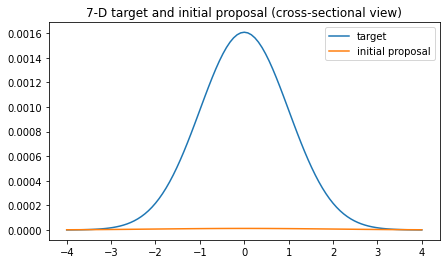

In [3]:
mle=MLE(dim=7,sigma=2)
size=20000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')

## KDE with different dimension and initial proposal

IS est: 1.0091; err: 0.0091; a-var: 2.4817; a-err: 0.0111
------------ pdf ratio at origin: 8.00 ------------


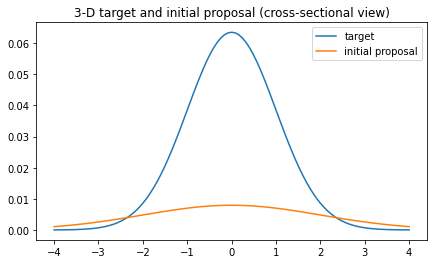

resample rate: 190/200
bdwth: 0.6809
NIS est: 1.0035; err: 0.0035; a-var: 0.2220; a-err: 0.0033
MIS est: 1.0022; err: 0.0022; a-var: 0.2914; a-err: 0.0038
------------ pdf ratio at origin: 1.72 ------------


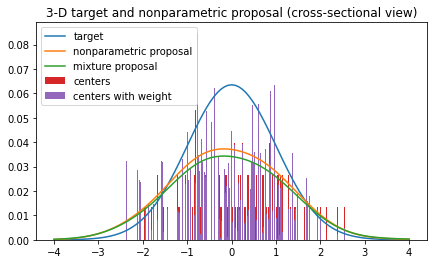

In [4]:
mle=MLE(dim=3,sigma=2)
size=20000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(200,20)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')

## Regression performance visualization

IS est: 0.9727; err: 0.0273; a-var: 6.6268; a-err: 0.0182
------------ pdf ratio at origin: 32.00 ------------


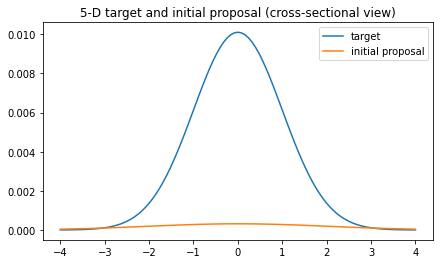

resample rate: 174/200
bdwth: 0.7505
NIS est: 0.9969; err: 0.0031; a-var: 0.5361; a-err: 0.0052
MIS est: 0.9981; err: 0.0019; a-var: 0.6542; a-err: 0.0057
------------ pdf ratio at origin: 3.26 ------------


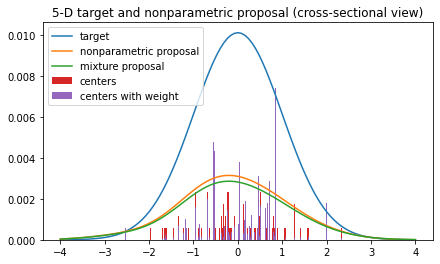

Ordinary R2: 0.9741; Lasso R2: 0.9180
RIS(Ord) est: 0.9984; err: 0.0016; a-var: 0.0170; a-err: 0.0009
RIS(Las) est: 0.9990; err: 0.0010; a-var: 0.0537; a-err: 0.0016
------------ pdf ratio at origin: 3.58 ------------
regression ratios: ordinary 1.0426, lasso 1.1618


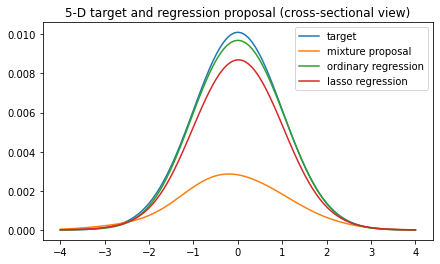

In [5]:
mle=MLE(dim=5,sigma=2)
size=20000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(200,20)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')
print('=======================================================')
mle.estimate_RIS(0.1)
mle.draw_TP(mle.mP,x,'regression')

## MLE method investigation

IS est: 1.0026; err: 0.0026; a-var: 18.0700; a-err: 0.0301
------------ pdf ratio at origin: 128.00 ------------


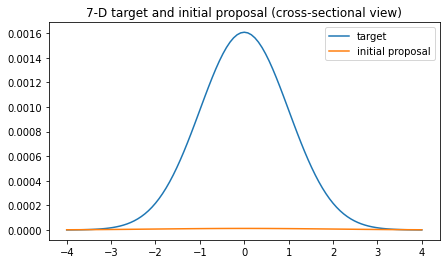

resample rate: 144/200
bdwth: 0.7920
NIS est: 0.9953; err: 0.0047; a-var: 1.2679; a-err: 0.0080
MIS est: 0.9940; err: 0.0060; a-var: 1.4161; a-err: 0.0084
------------ pdf ratio at origin: 5.88 ------------


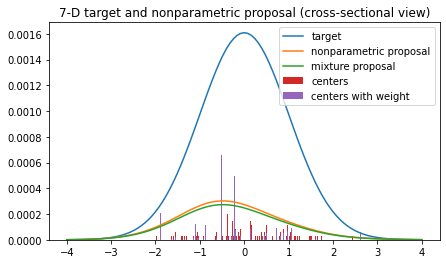

Ordinary R2: 0.6553; Lasso R2: 0.6306
RIS(Ord) est: 0.9988; err: 0.0012; a-var: 0.4881; a-err: 0.0049
RIS(Las) est: 0.9989; err: 0.0011; a-var: 0.5231; a-err: 0.0051
------------ pdf ratio at origin: 6.50 ------------
regression ratios: ordinary 1.3660, lasso 1.4938


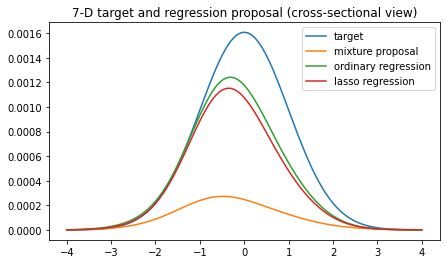

Reference:
origin: value: 11.8597; grad: (min -0.1459, mean 0.0053, max 0.2135, std 0.0564)

Theoretical results:
MLE(The) zeta: (min -0.0069, mean -0.0000, max 0.0073, std 0.0015, norm 0.0183)
theory: value: 11.8562; grad: (min -0.1514, mean -0.0053, max 0.0037, std 0.0176)
RIS(The) est: 0.9988; err: 0.0012
MLE(The) est: 0.9964; err: 0.0036

Optimization results:
MLE nit: 35, spent 12 seconds! 
MLE(Opt) zeta: (min -0.0067, mean -0.0000, max 0.0076, std 0.0015, norm 0.0181)
Dist(zeta(Opt),zeta(The))=0.0022
optimal: value: 11.8561; grad: (min -0.0000, mean 0.0000, max 0.0000, std 0.0000)
MLE(Opt) est: 0.9979; err: 0.0021


In [6]:
mle=MLE(dim=7,sigma=2)
size=20000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(200,20)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')
print('=======================================================')
mle.estimate_RIS(0.1)
mle.draw_TP(mle.mP,x,'regression')
print('=======================================================')
mle.estimate_MLE(True)